# Loading Data

In [3]:
from numbers import Number
from collections import defaultdict

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

import sina.datastores.sql as sina_sql
import sina.utils
from sina.datastore import create_datastore
from sina.visualization import Visualizer
import math

%matplotlib notebook

# Initialization
database = './data/num_res_output.sqlite'
target_type = "csv_rec"
datastore = create_datastore(database)
recs = datastore.records
vis = Visualizer(datastore)
print("Sina is ready!")


Sina is ready!


# Adding Data to Records

In [4]:
def RMSE(x_true, x_pred):
    summation = 0
    for xt, xp in zip(x_true,x_pred):
        summation += (xt-xp)**2
    mean = summation/len(x_true)
    rmse = math.sqrt(mean)
    return rmse

def diff(x_true, x_pred):
    dif = []
    for xt, xp in zip(x_true,x_pred):
        dif.append(xt-xp)
    return dif
        
###################################################
# Finding common timesteps using largest timestep #  
###################################################

val_largest_time_step = recs.get('47bcda_3_5')
x_largest_time_step = val_largest_time_step.data['x_pos']['value']
y_largest_time_step = val_largest_time_step.data['y_pos']['value']
z_largest_time_step = val_largest_time_step.data['z_pos']['value']
time_largest_time_step = val_largest_time_step.data['time']['value']


for rec in recs.get_all():
    
    x_pred = rec.data['x_pos']['value']
    y_pred = rec.data['y_pos']['value']
    z_pred = rec.data['z_pos']['value']
    time = rec.data['time']['value']
    
    x_pred_common = []
    y_pred_common = []
    z_pred_common = []
    time_common = []
    
    for i, t in enumerate(time):
        for t2 in time_largest_time_step:
            if t == t2:
                x_pred_common.append(x_pred[i])
                y_pred_common.append(y_pred[i])
                z_pred_common.append(z_pred[i])
                time_common.append(time[i])
                

    rec.add_data('time_common',time_common)
    rec.add_data('x_common',x_pred_common)
    rec.add_data('y_common',y_pred_common)
    rec.add_data('z_common',z_pred_common)
    
    recs.update(rec) # need to update or else won't save!!!!!
      
        
###############################################################
# Comparing to TICKS_PER_SECOND = 20 with new common timestep #  
###############################################################

val = recs.get('47bcda_3_20')
print(val.data.keys()) # since there are no embedded keys we can just use this
#print(val.curve_sets) # no curve sets

x_true = val.data['x_common']['value']
y_true = val.data['y_common']['value']
z_true = val.data['z_common']['value']
time_true = val.data['time_common']['value']

for rec in recs.get_all():
    
    x_pred = rec.data['x_common']['value']
    y_pred = rec.data['y_common']['value']
    z_pred = rec.data['z_common']['value']
    
    x_diff = diff(x_true, x_pred)
    x_rmse = RMSE(x_true, x_pred)
    y_diff = diff(y_true, y_pred)
    y_rmse = RMSE(y_true, y_pred)
    z_diff = diff(z_true, z_pred)
    z_rmse = RMSE(z_true, z_pred)
    
    print(x_rmse)
    print(y_rmse)
    print(z_rmse)
    
    rec.add_data('x_rmse',x_rmse)
    rec.add_data('x_diff',x_diff)
    rec.add_data('y_rmse',y_rmse)
    rec.add_data('y_diff',y_diff)
    rec.add_data('z_rmse',z_rmse)
    rec.add_data('z_diff',z_diff)
    
    recs.update(rec) # need to update or else won't save!!!!!


dict_keys(['x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial', 'gravity', 'box_side_length', 'group_id', 'time', 'x_pos', 'y_pos', 'z_pos', 'x_vel_final', 'y_vel_final', 'z_vel_final', 'num_bounces', 'time_common', 'x_common', 'y_common', 'z_common'])
10.048943553273888
3.6660280809096712
9.397580339308009
0.0
0.0
0.0
4.1208075609623505
1.6455319543704345
3.6956131082110675


# Parameter Table

In [5]:
header = 1
for rec in recs.get_all():
    
    if header == 1:
        print('| rec.id | x_pos_initial | y_pos_initial | z_pos_initial | x_vel_initial | y_vel_initial | z_vel_initial |')
        print('| --- | --- | --- | --- | --- | --- | --- |')
        header = 0
    print('|',rec.id,
          '|',rec.data['x_pos_initial']['value'],
          '|',rec.data['y_pos_initial']['value'],
          '|',rec.data['z_pos_initial']['value'],
          '|',rec.data['x_vel_initial']['value'],
          '|',rec.data['y_vel_initial']['value'],
          '|',rec.data['z_vel_initial']['value'],
          '|'
          )

| rec.id | x_pos_initial | y_pos_initial | z_pos_initial | x_vel_initial | y_vel_initial | z_vel_initial |
| --- | --- | --- | --- | --- | --- | --- |
| 47bcda_3_5 | 49.0 | 50.0 | 51.0 | 5.25 | 4.9 | 5.0 |
| 47bcda_3_20 | 49.0 | 50.0 | 51.0 | 5.25 | 4.9 | 5.0 |
| 47bcda_3_100 | 49.0 | 50.0 | 51.0 | 5.25 | 4.9 | 5.0 |


# Plotting QoIs and their Diff

<IPython.core.display.Javascript object>


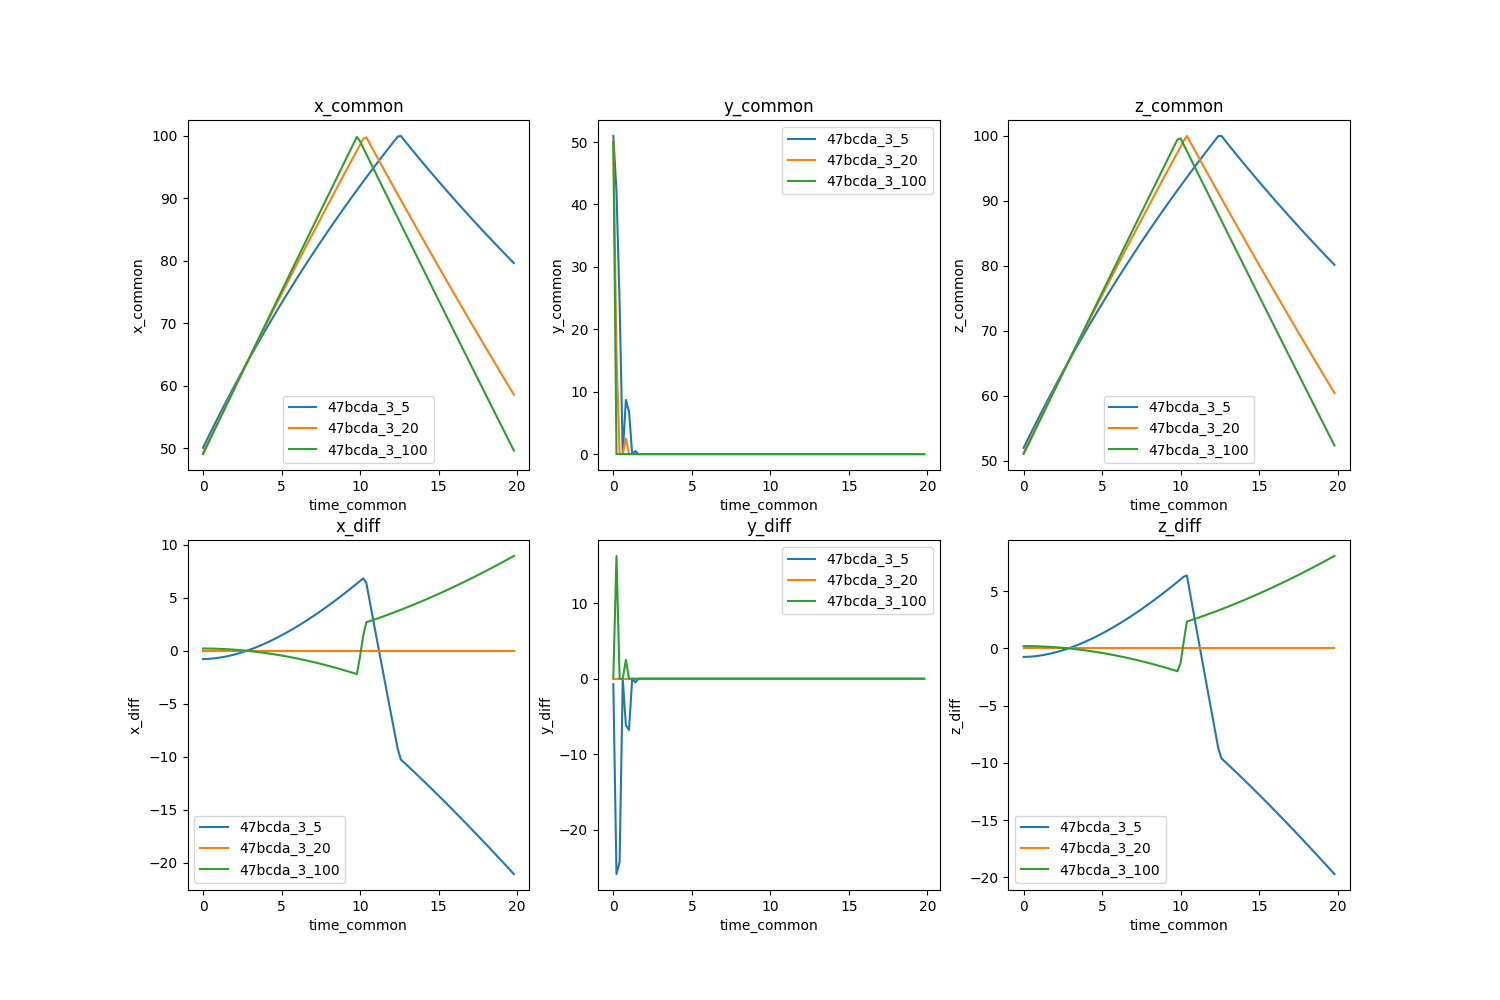

In [9]:
id_pool = list(recs.find_with_max("num_bounces", 1, ids_only=True))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))


_ = vis.create_line_plot(fig=fig, ax=ax[0,0],x="time_common", y="x_common", title = "{y_name}")
_ = vis.create_line_plot(fig=fig, ax=ax[0,1],x="time_common", y="y_common", title = "{y_name}")
_ = vis.create_line_plot(fig=fig, ax=ax[0,2],x="time_common", y="z_common", title = "{y_name}")

_ = vis.create_line_plot(fig=fig, ax=ax[1,0],x="time_common", y="x_diff", title = "{y_name}")
_ = vis.create_line_plot(fig=fig, ax=ax[1,1],x="time_common", y="y_diff", title = "{y_name}")
_ = vis.create_line_plot(fig=fig, ax=ax[1,2],x="time_common", y="z_diff", title = "{y_name}")

fig.savefig("./images/QoIs_num_res.png")